In [3]:
# Fill in your name using the format below and student ID number
your_name = "Jacobs, Mariska"
student_id = "1019990"

In [4]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [5]:
# Uncomment the following line to run in Google Colab
#!pip install --quiet openml 

In [6]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [8]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Mariska, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [9]:
#base_dir = '/content/drive/My Drive/assignment-3-Marjac' # For Google Colab
base_dir = './'

In [10]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [11]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [12]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [13]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [14]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

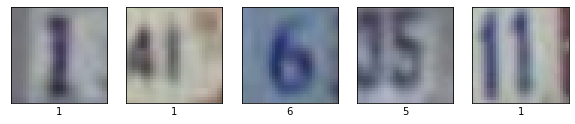

In [15]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [16]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

Training the model
Epoch 1/3
1986/1986 [==============================] - 8s 4ms/step - loss: 2.2453 - accuracy: 0.1905 - val_loss: 2.2330 - val_accuracy: 0.1910
Epoch 2/3
1986/1986 [==============================] - 8s 4ms/step - loss: 2.2333 - accuracy: 0.1910 - val_loss: 2.2331 - val_accuracy: 0.1910
Epoch 3/3
1986/1986 [==============================] - 8s 4ms/step - loss: 2.2333 - accuracy: 0.1910 - val_loss: 2.2330 - val_accuracy: 0.1910
Saving to file
Model stored in /content/drive/My Drive/assignment-3-Marjac
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110   

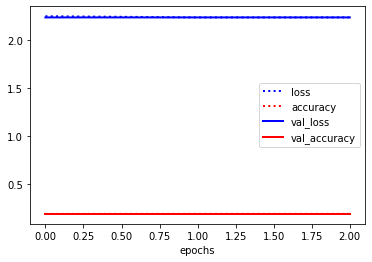

In [0]:
# # Toy usage example
# # Remove before submission
# from tensorflow.keras import models
# from tensorflow.keras import layers 

# def build_toy_model():
#     model = models.Sequential()
#     model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))
#     model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # First build and store
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
#                train=True, epochs=3, batch_size=32)

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233295  0.190466  2.232997      0.190974
max  2.245297  0.190970  2.233072      0.190974


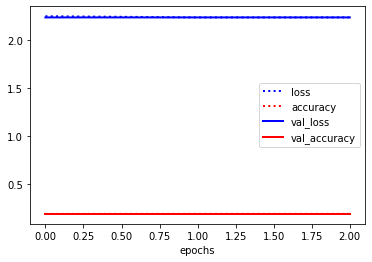

In [0]:
# # Toy usage example
# # Remove before submission
# # With train=False: load from file and report the same results without rerunning
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
#                train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 270)               829710    
_________________________________________________________________
dense_33 (Dense)             (None, 90)                24390     
_________________________________________________________________
dense_34 (Dense)             (None, 30)                2730      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                310       
Total params: 857,140
Trainable params: 857,140
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.720178  0.217220  0.

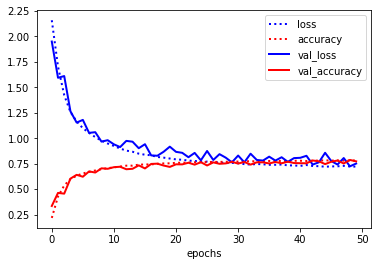

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model_1_1():
    model_1_1 = models.Sequential()
    model_1_1.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model_1_1.add(layers.Dense(270, activation='relu'))
    model_1_1.add(layers.Dense(90, activation='relu'))
    model_1_1.add(layers.Dense(30, activation='sigmoid'))
    model_1_1.add(layers.Dense(10, activation='sigmoid'))
    model_1_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_1_1
    
    
run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=50)

answer_q_1_1 = """The first layer needed more layers than subsequent ones, decreasing the top layer with factor 3 ensured a consistent decrease of nodes in the pyramid shape. The top layer was set at 270 to enable a decay of factor 3 with 4 layers ending at a layer with 10 nodes. Different combinations of relu, softmax and sigmoid were tried, but the layers with fewer nodes showed better accuracy with sigmoid and the layers consisting of more nodes yielded a higher accuracy with relu."""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [3]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    model_1_2 = models.Sequential()
    model_1_2.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model_1_2.add(layers.Dense(270, activation='relu'))
    model_1_2.add(layers.Dense(90, activation='relu'))
    model_1_2.add(layers.Dense(30, activation='sigmoid'))
    model_1_2.add(layers.Dense(10, activation='sigmoid'))
    model_1_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_1_2




# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=32)
answer_q_1_2 = """After preprocessing the data, so making them grayscale, to be noticed is a very slight increase in accuracy. This increase is because the function rgb2gray reduces complexity by converting 3 dimensions (r,g,b) into 1 dimension. Its only slightly because colors aren't determining for a number."""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 270)               276750    
_________________________________________________________________
dense_87 (Dense)             (None, 90)                24390     
_________________________________________________________________
dense_88 (Dense)             (None, 30)                2730      
_________________________________________________________________
dense_89 (Dense)             (None, 10)                310       
Total params: 304,180
Trainable params: 304,180
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.590900  0.188468  0.

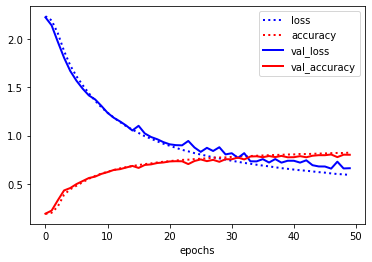

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

def build_model_1_3():
    model_1_3 = models.Sequential()
    model_1_3.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model_1_3.add(layers.Dense(270, activation='relu', 
                               #kernel_regularizer=regularizers.l2(0.00005),
                                #activity_regularizer=regularizers.l2(0.00005), 
                                   bias_regularizer=regularizers.l2(0.00005)
                              ))
    #model_1_3.add(layers.Dropout(0.1))
    model_1_3.add(layers.Dense(90, activation='relu', 
                               #kernel_regularizer=regularizers.l2(0.00005),
                                #activity_regularizer=regularizers.l2(0.00005), 
                                   bias_regularizer=regularizers.l2(0.00005)
                              ))
    #model_1_3.add(layers.Dropout(0.2))
    model_1_3.add(layers.Dense(30, activation='sigmoid', 
                               #kernel_regularizer=regularizers.l2(0.01),
                                #activity_regularizer=regularizers.l1(0.01), 
                                   #bias_regularizer=regularizers.l2(0.00005)
                              ))
    #model_1_3.add(layers.Dropout(0.5))
    model_1_3.add(layers.Dense(10, activation='sigmoid',
                               #kernel_regularizer=regularizers.l2(0.01),
                                #activity_regularizer=regularizers.l1(0.01), 
                                   #bias_regularizer=regularizers.l2(0.00005)
                              ))
    model_1_3.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model_1_3

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=50)
answer_q_1_3 = """Many combinations of regularizers were tried. For all layers, bias gave highest accuracy. L2 gave higher accuracy than L1. Thereby, a L2 regularized model is more resistant to overfitting. In literature on regularization hyperparameters, 0.0005 is often reported and works well for this model. The optimizer now includes a learning rate of 0.0001, giving high accuracy while keeping training fast."""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 30)        300       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 30)        8130      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 30)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 30)        120       
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 30)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 60)        16260     
_________________________________________________________________
conv2d_33 (Conv2D)   

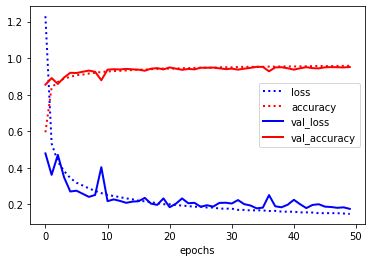

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models

def build_model_2_1():
    model_2_1 = models.Sequential()
    model_2_1.add(layers.Conv2D(30, (3, 3), activation='relu', input_shape=(32, 32, 1),padding='same'))
    model_2_1.add(layers.Conv2D(30, (3, 3), activation='relu', padding='same'))
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Dropout(0.2))
    model_2_1.add(layers.Conv2D(60, (3, 3), activation='relu', padding='same'))
    model_2_1.add(layers.Conv2D(60, (3, 3), activation='relu', padding='same'))
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Dropout(0.4))
    model_2_1.add(layers.Conv2D(90, (3, 3), activation='relu',padding='same'))
    model_2_1.add(layers.Conv2D(90, (3, 3), activation='relu',padding='same'))
    model_2_1.add(layers.MaxPooling2D((2, 2)))
    model_2_1.add(layers.BatchNormalization())
    model_2_1.add(layers.Dropout(0.6))
    model_2_1.add(layers.Flatten())
    model_2_1.add(layers.Dense(10, activation='sigmoid'))
    model_2_1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_2_1

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=70)
answer_q_2_1 = """When building a sequential convolutional neural network, it is important to have sufficient filters in the first layer, otherwise information gets lost. Therefore, started is with 30 filters. Adviced is to use, in deeper layers, increasingly more filters.
               MaxPooling layers were added to reduce resolution and to increase translation invariance. This ensures that it doesnt matter where in the image the object is present. Zero padding was addded each Conv2D layer to build a deeper model.
               A dropout that gradually increases in the amount of dropout was added to force layers located deeper in the model to regularize more than layers closer to the input.
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 32, 32, 30)        300       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 30)        8130      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 30)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 16, 30)        120       
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 30)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 16, 16, 60)        16260     
_________________________________________________________________
conv2d_57 (Conv2D)  

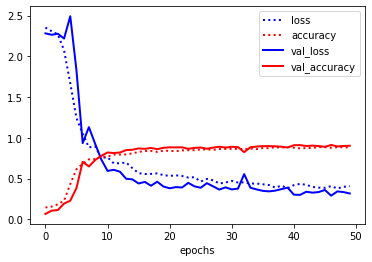

In [22]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val


train_datagen = ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=2, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='wrap', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=False, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
    )

it_train = train_datagen.flow(preprocessed_split[0], preprocessed_split[2], batch_size=64)

augmented_split = it_train, preprocessed_split[1], preprocessed_split[3]

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, generator=True, epochs=50, batch_size=None)
answer_q_2_2 = """Flipping didn't increase accuracy, but digits don't occur mirrored or upside down. Unexpectedly, zoom and shifting don't add accuracy. Images might shift/zoom worse, since it can't be specified for each image. For fill modes, wrap gives highest accuracy. Constant and increasing cval underfits heavily. 20% rotation was worse for all fill modes: digits might be turned such they won't occur in streetview. 2% rotation reduced overfitting for some accuracy reduction. Still, model 2.1 outperforms 2.2"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

621/621 [==============================] - 4s 6ms/step - loss: 0.3164 - accuracy: 0.9057


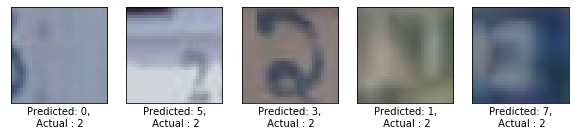

[0.31644636392593384, 0.905730664730072]
Answer is 795 characters long


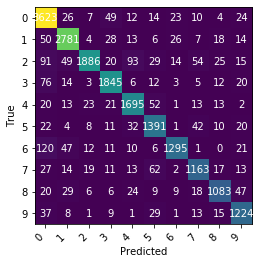

In [42]:
from sklearn.metrics import confusion_matrix

model_2_2 = load_model_from_file(base_dir=base_dir, name="model_2_2")
test_accuracy_3_1 = model_2_2.evaluate(rgb2gray(X_test), y_test)

y_pred = model_2_2.predict(rgb2gray(X_test))
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]


def plot_confusion_matrix():
  
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels((0,1,2,3,4,5,6,7,8,9), rotation=45, ha="right")
    ax.set_yticklabels((0,1,2,3,4,5,6,7,8,9))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

def plot_misclassifications():
    fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
    #prints only the images with actual label defined after == to see what mistakes are made for the class
    for nr, i in enumerate([x for x in misclassified_samples if ((np.argmax(y_test[x])+1)%10) == 2][5:10]):
      axes[nr].imshow(X_test[i])
      axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (((np.argmax(y_pred[i])+1)%10),((np.argmax(y_test[i])+1)%10)))
      axes[nr].set_xticks(()), axes[nr].set_yticks(())
      #print(y_val[i])
    plt.show();

plot_misclassifications()    
plot_confusion_matrix()
print(test_accuracy_3_1)
answer_q_3_1 = """In the matrix, we see that there are many misclassifications 6 and 0, 2 and 7, 2 and 4. 6 and 0 are understandable, they both have a round shape. Interestingly, 2's are often misclassified as 7 or 4, but 7's and 4's not as 2. Also, the model predicts numbers falsely as 0 a lot. Zooming in on a digit, we look at 2 to see the resemblance with 7 and 4. From the first 5 images, clearly noisiness in the image is present in terms of blurriness. For 3 out of 5 images, the human eye can't even tell. The same holds for images further on in the dataset. Also noticeable is the different ways of writing a 2: The bend can have a big curve or a straight line like a 7, the bottom can be wavy at the or straight lined, which is similar to the corner a 4 makes and explains the error made between these."""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

<ipython-input-48-c5ff923301ef>:37: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
<ipython-input-48-c5ff923301ef>:37: RuntimeWarning: divide by zero encountered in true_divide
  channel_image /= channel_image.std()


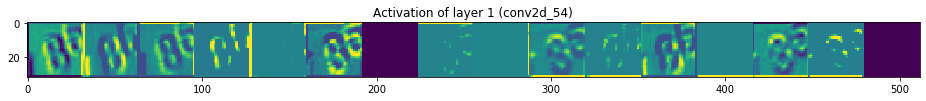

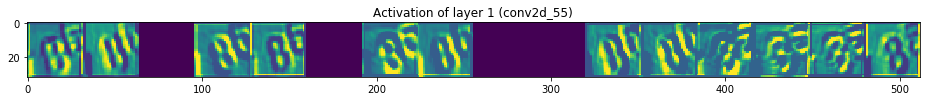

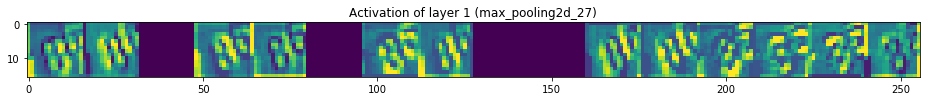

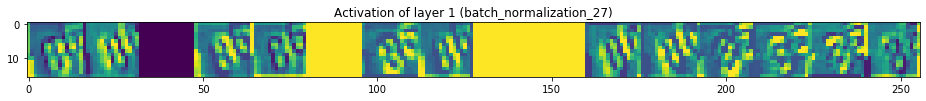

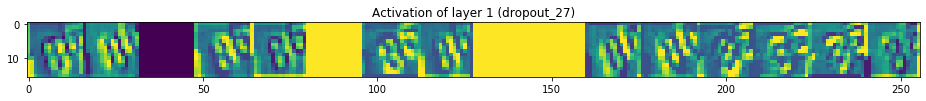

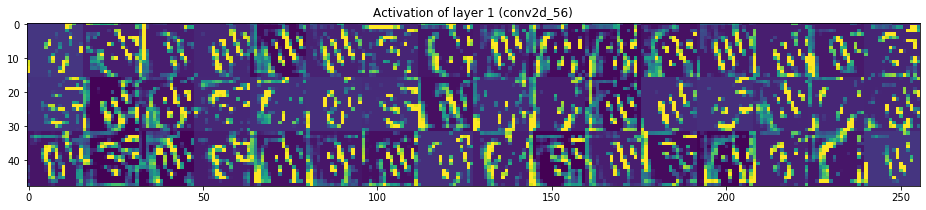

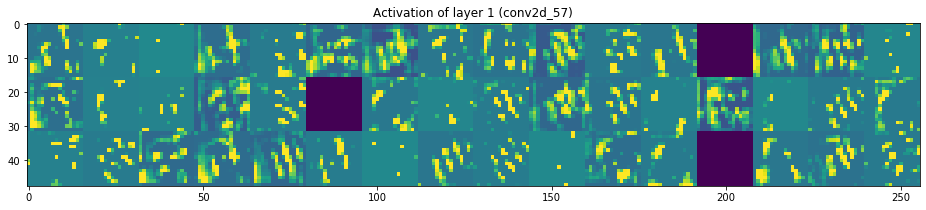

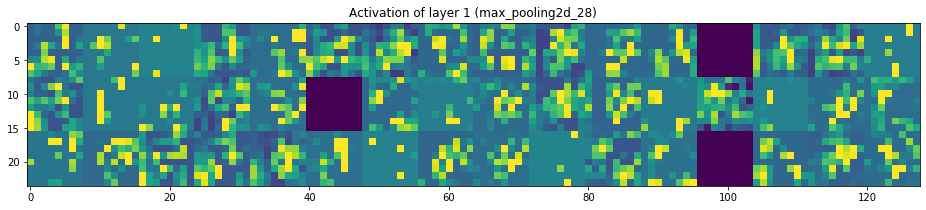

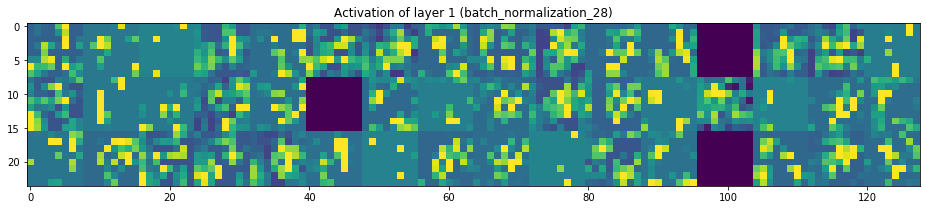

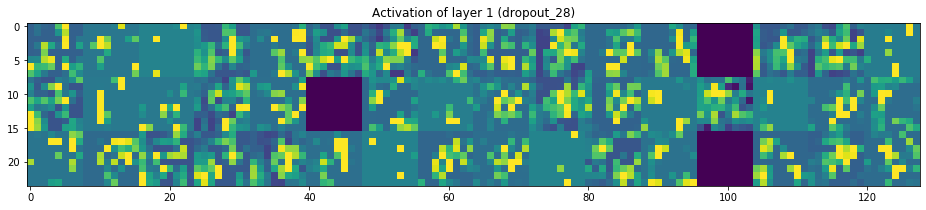

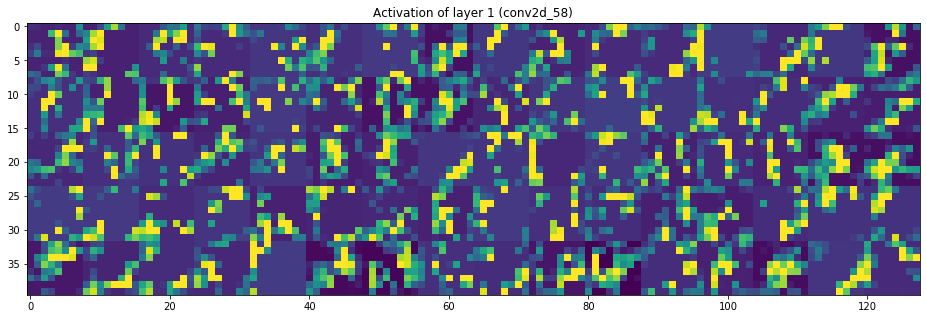

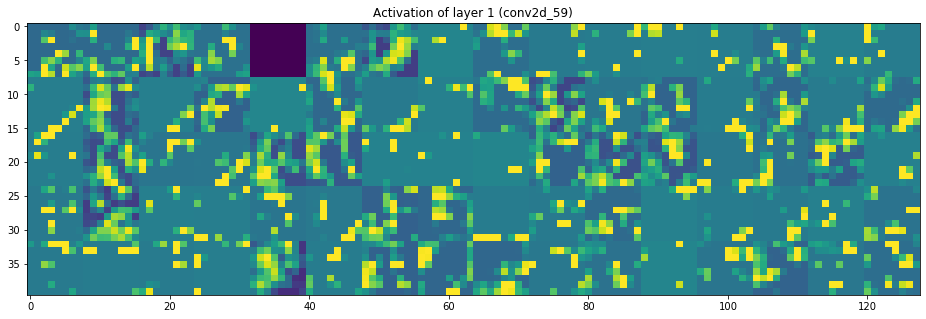

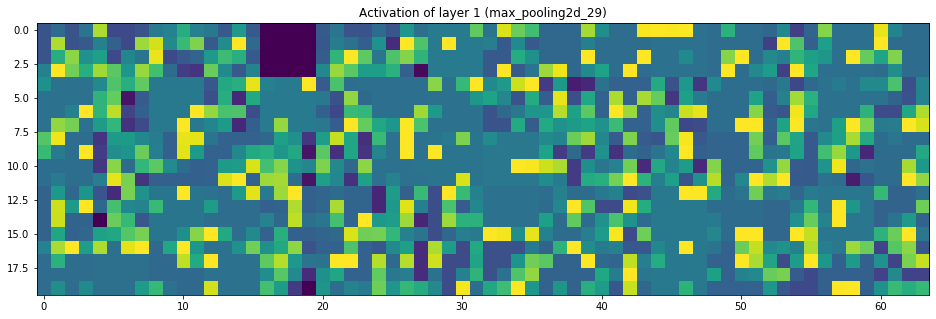

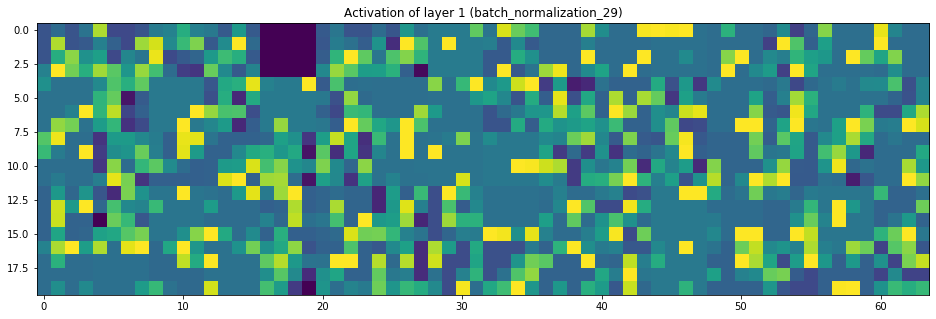

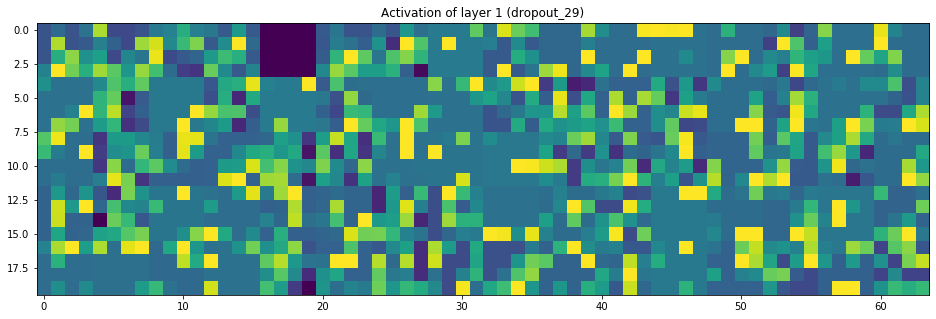

Answer is 498 characters long


In [48]:
from tensorflow.keras import models
#plot_activations adapted from: https://github.com/anastasios-stamoulis/deep-learning-with-csharp-and-cntk/blob/master/Python/ch5-4.py

img_tensor = rgb2gray(X_test)[0]
img_tensor = np.expand_dims(img_tensor, axis=0) 

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_2_2.layers[:15]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

images_per_row = 16

layer_names = []
for layer in model_2_2.layers[:15]:
    layer_names.append(layer.name)

def plot_activations():
  
    layer_index = 0

    for layer_name, layer_activation in zip(layer_names[0:18], activations[0:18]):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

plot_activations()

answer_q_3_2 = """The 1st layer focuses on outline, the 2nd has more activation on the outline parts that were weaker in the 1st layer. Deeper Conv2d layers have bigger abstraction. The 3rd layer still has the shape of a digit, in the 4th Conv2d layer, a digit is hardly recognized. In the deepest two Conv2d layers, patterns are very abstract. From these last layers, the model appears to not learn what defines an 8: its roundness and the two circles on top of each other, but focuses on entirely different things."""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

In [2]:
import cv2
from tensorflow.keras import backend as K
from matplotlib.pyplot import *

def plot_activation_map():  
  #select the first example from the test set
  image = X_test[0]
  image = np.expand_dims(image, axis=0)
  image = rgb2gray(image)

  model = load_model_from_file(base_dir=base_dir, name="model_2_2")
  preds = model.predict(image)
  
  image_output = model.output[:, 7]

  last_conv_layer = model.get_layer('conv2d_59')

  grads = K.gradients(image_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate(image)

  for i in range(89):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  #create heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)
  plt.show()

  #superimpose the activation map over the image
  img = rgb2gray(X_test)[0]
  heatmap2 = heatmap  
  heatmap2 = cv2.resize(heatmap2, (img.shape[1], img.shape[0]))    
  heatmap2 = np.uint8(255 * heatmap2)    
  heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)    
  superimposed_img = heatmap2 * 0.4 + img
  imshow(superimposed_img) 
  #cv2.imwrite('/content/cache/superimposed_img.jpg', superimposed_img)
  #show_image = cv2.imread('/content/cache/superimposed_img.jpg')
  #imshow(show_image)

def plot_3_3():
    pass
  
tf.compat.v1.disable_eager_execution() 
plot_activation_map()
plot_3_3()

NameError: name 'tf' is not defined

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Answer is 722 characters long
Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/10
63544/63544 [==============================] - 40s 637us/sample - loss: 1.0729 - accuracy: 0.6337 - val_loss: 0.8531 - val_accuracy: 0.7176
Epoch 2/10
63544/63544 [==============================] - 39s 620us/sample - loss: 0.7660 - accuracy: 0.7461 - val_loss: 0.7343 - val_accuracy: 0.7537
Epoch 3/10
63544/63544 [==============================] - 39s 618us/sample - loss: 0.6813 - accuracy: 0.7749 - val_loss: 0.6660 - val_accuracy: 0.7791
Epoch 4/10
63544/63544 [==============================] - 39s 618us/sample - loss: 0.6284 - accuracy: 0.7931 - val_loss: 0.6741 - val_accuracy: 0.7857
Epoch 5/10
63544/63544 [==============================] - 39s 619us/sample - loss: 0.5945 - accuracy: 0.8042 - val_loss: 0.6575 - val_accuracy: 0.7874
Epoch 6/10
63544/63544 [==============================] - 39s 618us/sample - loss: 0.5651 - accuracy: 0.8135 - val_loss: 0.6210 - val_accuracy: 0.

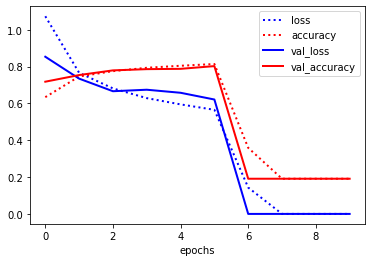

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16


def build_model_4_1():
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
  model_4_1 = models.Sequential()
  model_4_1.add(conv_base)
  model_4_1.add(layers.Flatten())
  model_4_1.add(layers.Dense(300, activation='relu'))
  model_4_1.add(layers.Dense(10, activation='sigmoid'))

  for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        layer.trainable = True
    if layer.name == 'block5_conv2':
        layer.trainable = True
    if layer.name == 'block5_conv1':
        layer.trainable = True        
    else:
        layer.trainable = False

  model_4_1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model_4_1

answer_q_4_1 = """The added dense layer has 300 units, which was an arbitrary value. The dense layer with 10 units was needed for run_evaluation to run. Since the model takes a long time to load, checked was for 3 epochs each run. Freezing the convolutional base, makes the model start with a higher accuracy than without freezing the base. Freezing the entire model makes the accuracy and the loss stay the same after each epoch. Unfreezing only the last convolutional layer does not make a lot of difference, however unfreezing entire block 5 gives high accuracy from the first epoch already. Unfreezing all layers accept block 5 and running this for 10 epochs yields a graph that show little over or underfitting but has a big drop in accuracy and loss after a few epochs."""
print("Answer is {} characters long".format(len(answer_q_4_1)))

build_model_4_1()
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=70)

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [1]:
import pickle
import gzip
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def store_embedding(X, name):  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model_4_1 = load_model_from_file(base_dir=base_dir, name="model_4_1")
  
  model_4_1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  history_train = model_4_1.fit(X_train, y_train, epochs=3, batch_size=70, verbose=1,
                    validation_data=(X_test, y_test))
  
  store_embedding(history_train, "embedding")

def generate_pipeline():
  """ Returns an sklearn pipeline.
  """
  pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
  """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
  """
  scores = cross_val_score(pipe, X_train, y_train)
  print("Cross-validated R^2 score for {}: {:.2f}".format(regressor.__class__.__name__, scores.mean()))

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  #evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test)

answer_q_4_2 = """
               Your answer 
               """
#print("Pipeline:",generate_pipeline())
#print("Answer is {} characters long".format(len(answer_q_4_2)))
#store_embeddings()

Pipeline: None
Answer is 44 characters long
